In [1]:
import os, re
import pandas as pd
import numpy as np
import json

from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline
plt.rcParams['font.size'] = 22

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from csw2022 import *

In [3]:
## include information about tonode response in dataframes
dfL = []
for cidx in range(2):
  condition = ['interleaved','interleaved_rep'][cidx]
  _df = load_final_df(condition)

  # if true on right, right_node = true_tonode
  for i,d in _df.iterrows():
    ## find right node and left node
    _df.loc[i,'right_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][int(d.true_on_right)]
    ]
    _df.loc[i,'left_state'] = node2stateD[
      [d.true_tonode,d.false_tonode][np.abs(1-int(d.true_on_right))]
    ]

  ## find response node
  for i,df_row in _df.iterrows():
    _df.loc[i,'response_state'] = [df_row.left_state,df_row.right_state][int(df_row.response_right)]

  ## schema index
  _df.loc[:,'schema_idx'] = (_df.true_rfc.str.split('_').str[-1].str.split('-').str[1] == 'jungle').astype(int)
  dfL.append(_df)

  ## 
df_i,df_ir = dfL


-loading code version: RT01B1000cl
N = 55 subjects

-loading code version: csw1000block01.04.25.19
N = 56 subjects


### dataframe processing

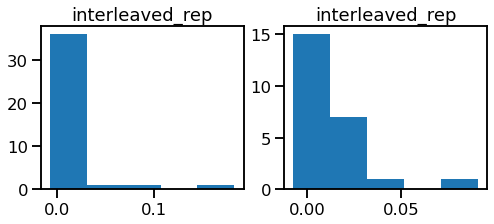

In [4]:
fg,axar = plt.subplots(1,2,figsize=(8,3))
for cidx in range(2):
  ax = axar[cidx]
  df = dfL[cidx]
  ## compute adjusted rand (only for 3/4=>5/6)
  adjrandL = []
  for idx, sub_df in df.groupby('subjnum'):
    for jdx, sub_depth_df in sub_df.groupby('depth'):
      if jdx == 2: continue
      sub_ar = adjusted_rand_score(
        sub_depth_df.response_state.values,
        sub_depth_df.schema_idx.values
      )
      adjrandL.append(sub_ar)
      
  ## plot
  adjRand = np.array(adjrandL)
  ax.hist(adjRand,bins=5)
  ax.set_title(condition)
#   plt.savefig('figures/interleaved-adjrand')

# moving window adjusted rand

In [5]:
def windowed_ar(X,Y,window):
  assert len(X)==len(Y)
  AR = -np.ones(len(X)-window)
  for wi in range(len(X)-window):
    AR[wi] = adjusted_rand_score(
      X[wi:wi+window],
      Y[wi:wi+window]
    )
  return AR

In [6]:
cidx = 1
condition = ['interleaved','interleaved_rep'][cidx]
df = [df_i,df_ir][cidx]

def compute_windowed_adjrand(df,window=20):
  """ returns list of list because 
  different subjects have different number of timepoints
  """
  subnums = df.index.get_level_values('subjnum').unique()
  Nsubs = subnums.shape[0]
  marLoL = []
  for idx,(sidx,sub_df) in enumerate(df[df.index.get_level_values('depth')==2].groupby(['subjnum'])):
    sub_win_ar = windowed_ar(
      sub_df.response_state.values,
      sub_df.schema_idx.values,
      window
    )
    marLoL.append(sub_win_ar)
  return marLoL

warL = compute_windowed_adjrand(df,window=20)
len(warL),warL[0].shape # each subject one array (varying length) in list

(24, (120,))

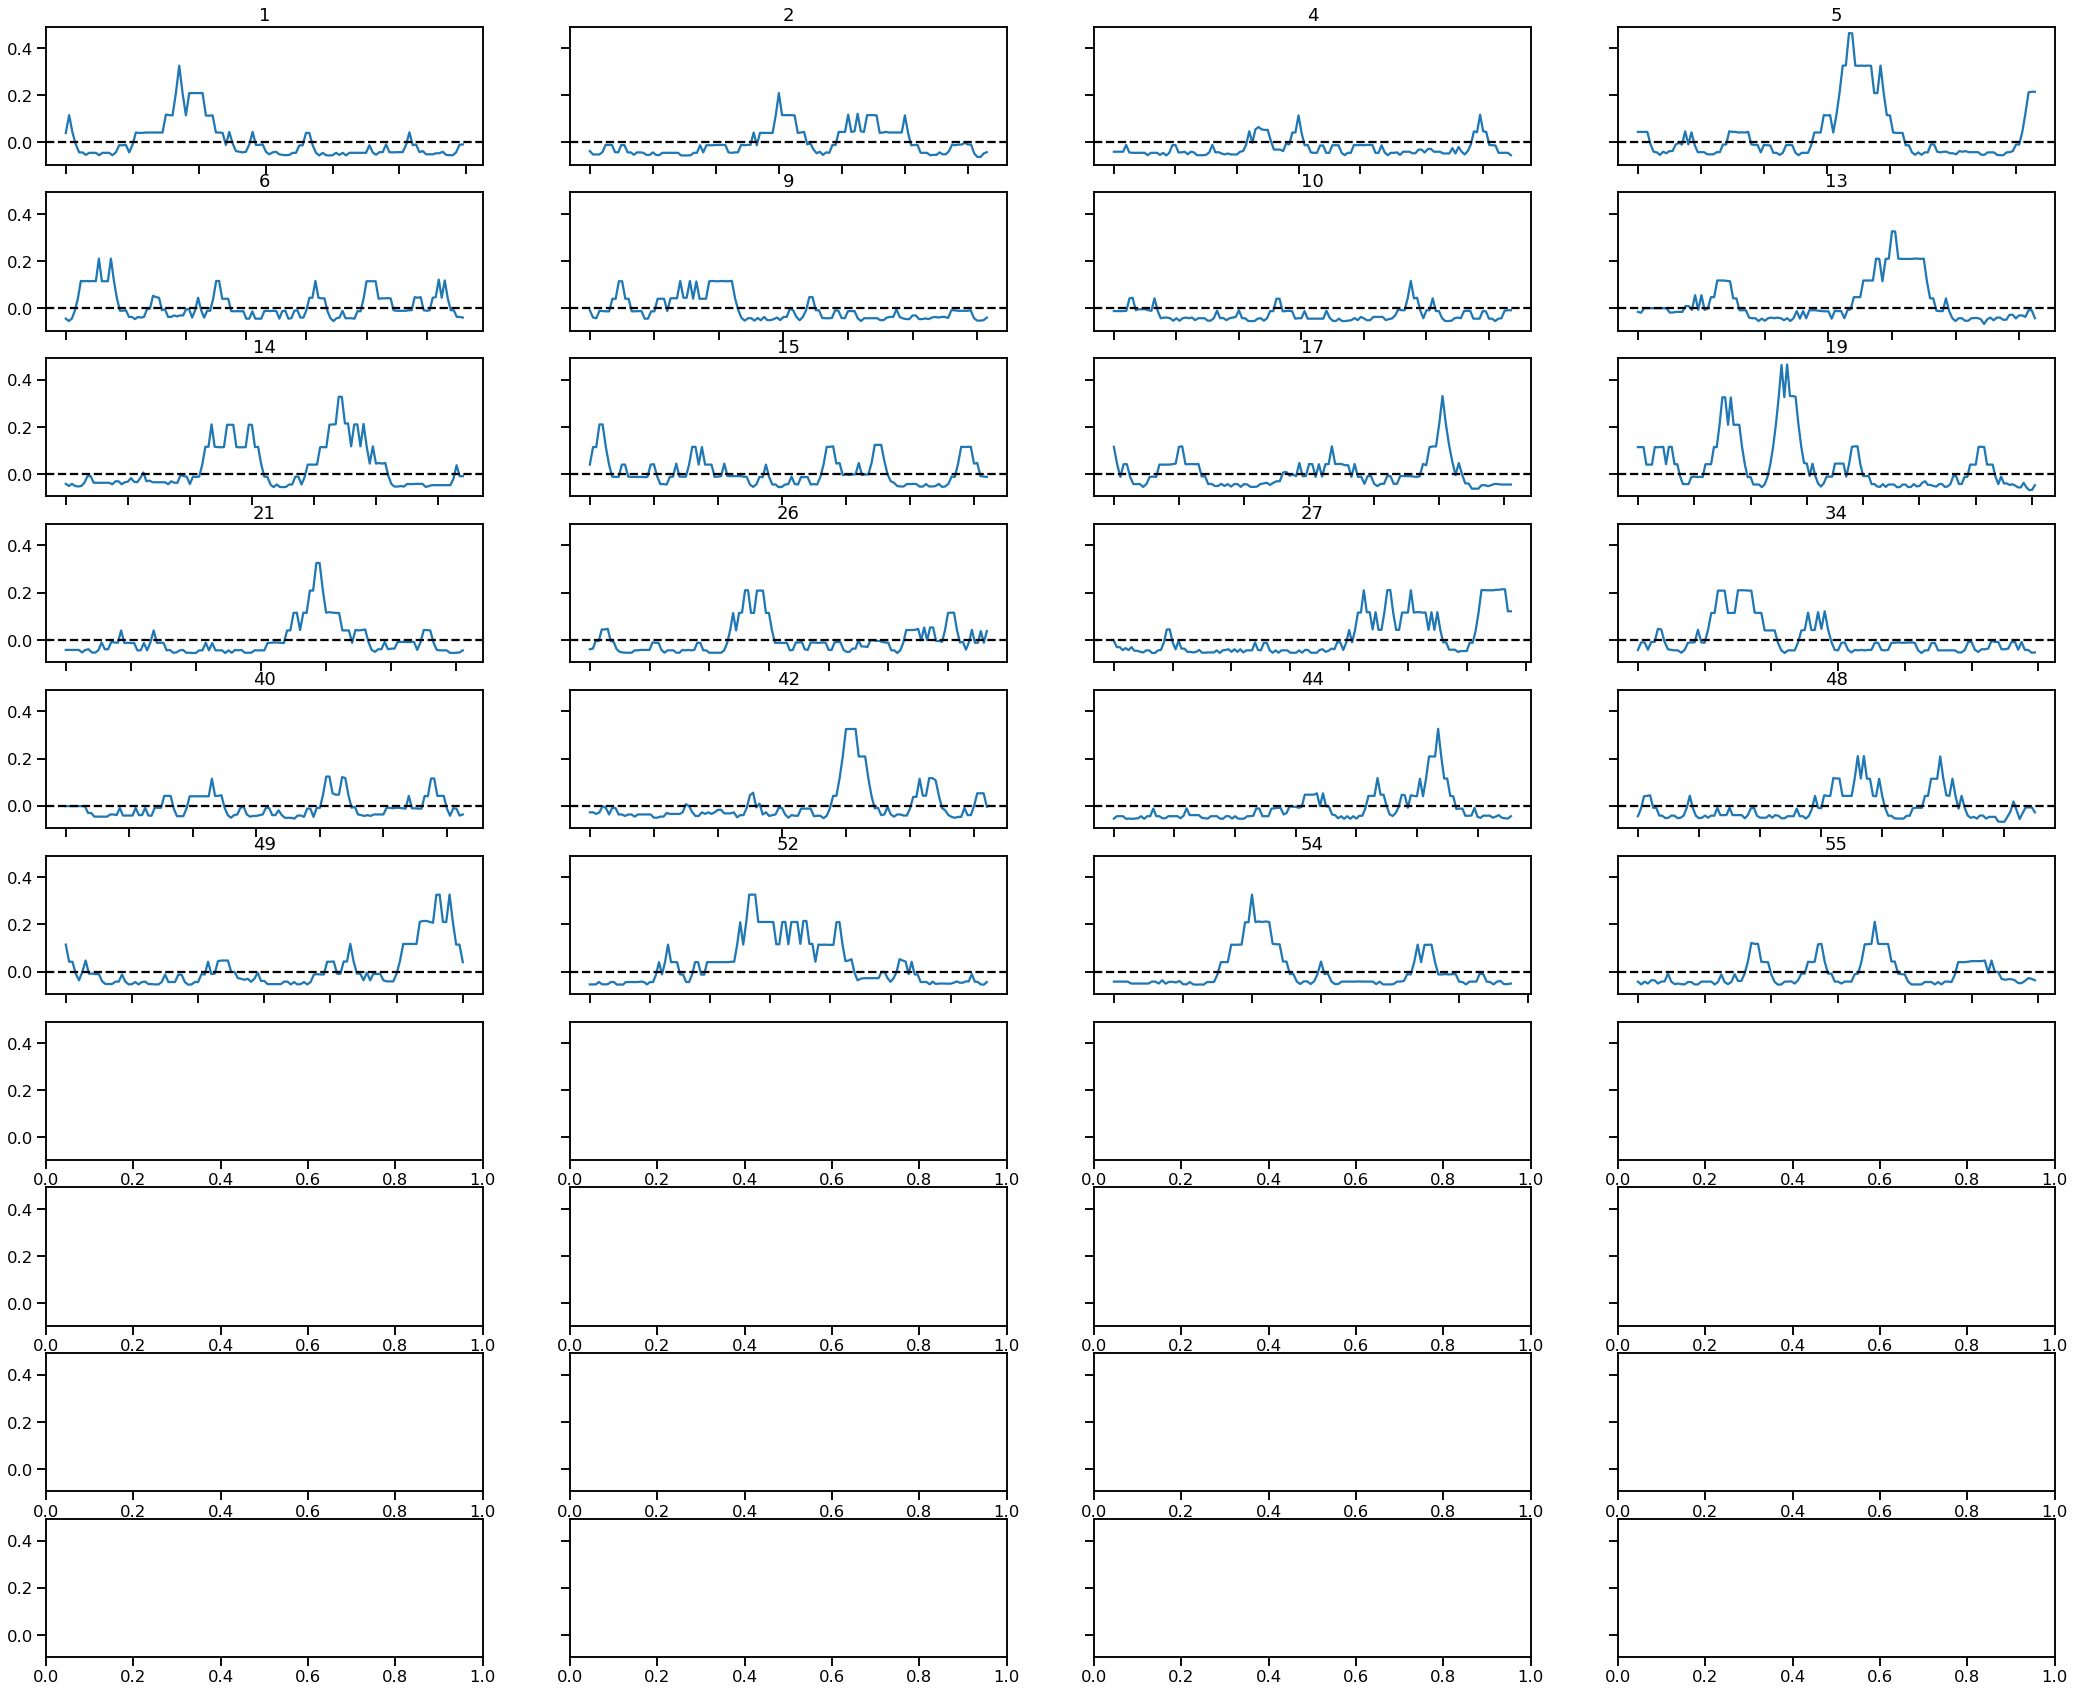

In [7]:
subnums = df.index.get_level_values('subjnum').unique()
fig,axarr = plt.subplots(10,4,figsize=(36,30),sharey=True);axarr=axarr.reshape(-1)
for idx in range(len(warL)):
  ax=axarr[idx]
  ax.set_title(subnums[idx])
  ax.plot(warL[idx])
  ax.axhline(0,c='k',ls='--')
  ax.set_xticklabels([])

In [8]:
def compute_null_windowed_adjrand(df,window,nitr):
  """ returns list of arrays  
  each subject has an array of null values for that subject's experiment sequence
  subjects have different number of timepoints
  """
  subnums = df.index.get_level_values('subjnum').unique()
  Nsubs = subnums.shape[0]
  marLoA = []
  # loop over subjects
  for idx,(sidx,sub_df) in enumerate(df[df.index.get_level_values('depth')==2].groupby(['subjnum'])):
    # loop over itr
    sub_exp_len = sub_df.shape[0]
    null_sub_resp = np.random.choice([2,3],[nitr,sub_exp_len])
    null_sub_AR = -np.ones([nitr,sub_exp_len-window])
    for itr in range(nitr):
      null_sub_AR[itr] = windowed_ar(
        sub_df.schema_idx.values,
        null_sub_resp[itr],
        window=window
      )
      
    marLoA.append(null_sub_AR)
  return marLoA


# null_warL = compute_null_windowed_adjrand(df_i,window=20,nitr=100)
# len(null_warL),null_warL[0].shape,null_warL[1].shape

In [9]:
def war_metric(sub_war,null_sub_war,threshold=0.05):
  """ 
  sub_war: 1d array [exp_len-window] subject windowed ar
  null_sub_war: 2d array [itr,exp_len-window], nitr nulls for sub
  returns: sub_metric, metric_null_distr
  """
  sub_metric = np.sum(sub_war>threshold)
  null_distr_metric = np.sum(null_sub_war>threshold,1)
  return sub_metric,null_distr_metric

# def war_metric_group()

In [ ]:
## compute and save windowed adjrand
nitr_null = 100
for cidx in range(2):
  print('cond',cidx)
  condition = ['interleaved','interleaved_rep'][cidx]
  df = [df_i,df_ir][cidx]
  subnums = df.index.get_level_values('subjnum').unique()
  for window in [5,10,20]:
    print('window',window)
    warL = compute_windowed_adjrand(df,window)
    null_warL = compute_null_windowed_adjrand(df,window,nitr_null)
    for idx,sidx in enumerate(subnums):
      sub_war = warL[idx]
      sub_null_war = null_warL[idx]
      np.save('analysis_data/window_ajusted_rand/s%.2i-war-window_%.2f-%s'%(
        sidx,window,condition),
              sub_war
             )
      np.save('analysis_data/window_ajusted_rand/s%.2i-null_war-window_%.2f-%s'%(
        sidx,window,condition),
              sub_null_war
             )

cond 0
window 5
window 10


In [11]:
# def make_war_kdeplt(warL,null_warL,thresh):
#   subnums = df.index.get_level_values('subjnum').unique()
#   fig,axarr = plt.subplots(10,4,figsize=(36,30),sharey=True,sharex=True);axarr=axarr.reshape(-1)
#   for idx in range(len(warL)):
#     ## get subject data
#     sub_war = warL[idx]
#     null_sub_war = null_warL[idx]
#     ## metric
#     sub_metric,null_distr_metric = war_metric(sub_war,null_sub_war,thresh)
#     ## plot
#     ax=axarr[idx]
#     ax.set_title(subnums[idx])
#     sns.kdeplot(null_distr_metric,ax=ax)
#     ax.axvline(sub_metric,c='r')
#     ax.axvline(0,c='k')
#   return None
    
# make_war_kdeplt(warL,null_warL,thresh)
# plt.savefig('figures/kde_mov_ar-window_%i-metric_thresh_%.2f-%s.png'%(window,thresh,condition))

NameError: name 'thresh' is not defined